In [5]:
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [6]:
root = Path('data/Task02_Heart/imagesTr')
label = Path('data/Task02_Heart/labelsTr')

In [7]:
def change_img_to_label_path(path):
    parts = list(path.parts)
    parts[parts.index('imagesTr')] = 'labelsTr'

    return Path(*parts)

In [8]:
sample_path = list(root.glob('la*'))[0]
sample_path_label = change_img_to_label_path(sample_path)

sample_path, sample_path_label

(PosixPath('data/Task02_Heart/imagesTr/la_010.nii.gz'),
 PosixPath('data/Task02_Heart/labelsTr/la_010.nii.gz'))

In [9]:
data = nib.load(sample_path)
label = nib.load(sample_path_label)

mri = data.get_fdata()
mask = label.get_fdata().astype(np.uint8)

In [10]:
nib.aff2axcodes(data.affine)

('R', 'A', 'S')

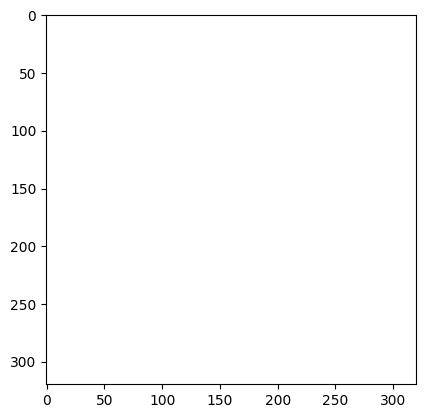

In [11]:
from celluloid import Camera
from IPython.display import HTML

fig = plt.figure()
camera = Camera(fig)

for i in range(mri.shape[2]):
    plt.imshow(mri[:, :, i], cmap='bone')
    mask_ = np.ma.masked_where(mask[:, :, i] == 0, mask[:, :, i])
    plt.imshow(mask_, alpha=0.5)
    camera.snap()

animation = camera.animate()

In [12]:
HTML(animation.to_html5_video())

## Preprocessing

In [15]:
def normalize(full_volume):
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std

    return normalized

def standardize(normalized):
    standardized = (normalized - normalized.min()) / (normalized.max() - normalized.min())

    return standardized

In [16]:
all_files = list(root.glob('la*'))
len(all_files)

20

In [17]:
save_root = Path('processed/Task02_Heart')

for counter, path_to_mri_data in enumerate(tqdm(all_files)):
    path_to_label = change_img_to_label_path(path_to_mri_data)
    mri = nib.load(path_to_mri_data)

    assert nib.aff2axcodes(mri.affine) == ('R', 'A', 'S')

    mri_data = mri.get_fdata()
    label_data = nib.load(path_to_label).get_fdata().astype(np.uint8)

    mri_data = mri_data[32:-32, 32:-32]
    label_data = label_data[32:-32, 32:-32]

    normalized_mri_data = normalize(mri_data)
    standardized_mri_data = standardize(normalized_mri_data)

    if counter < 17:
        current_path = save_root / "train" / str(counter)
    else:
        current_path = save_root / 'val' / str(counter)

    for i in range(standardized_mri_data.shape[-1]):
        slice_data = standardized_mri_data[:, :, i]
        mask = label_data[:, :, i]
        slice_path = current_path / 'data'
        mask_path = current_path / 'masks'
        slice_path.mkdir(parents=True, exist_ok=True)
        mask_path.mkdir(parents=True, exist_ok=True)

        np.save(slice_path / str(i), slice_data)
        np.save(mask_path / str(i), mask)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
path = Path('processed/Task02_Heart/train/0')

file = '50.npy'
slice_data = np.load(path / 'data' / file)
mask = np.load(path / 'masks' / file)

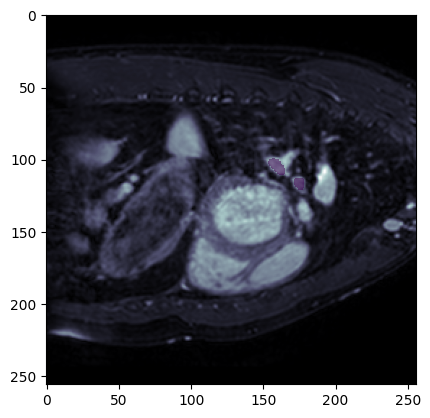

In [ ]:
plt.figure()
plt.imshow(slice_data, cmap='bone')
mask_ = np.ma.masked_where(mask == 0, mask)
plt.imshow(mask_, alpha=0.5)

## Dataset Creation

In [ ]:
from pathlib import Path
import torch
import numpy as np
import imgaug
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [ ]:
class CardiacDataset(torch.utils.data.Dataset):
    def __init__(self, root, augment_params):
        super().__init__()
        self.all_files = self.extract_files(root)
        self.augment_params = augment_params

    @staticmethod # Means it never accesses any class attributes and doesn't need the 'self' argument
    def extract_files(root):
        files = []

        for subject in root.glob('*'):
            slice_path = subject / 'data'

            for slice_data in slice_path.glob('*.npy'):
                files.append(slice_data)

        return files

    @staticmethod
    def change_img_to_label_path(path):
        '''
        Replaces 'imagesTr' with 'labelsTr'
        '''
        parts = list(path.parts) # get all directories within the path
        parts[parts.index('data')] = 'masks' # Replace 'imagesTr' with 'labelsTr'

        return Path(*parts) # Combine list back into a Path object

    def augment(self, slice_data, mask):
        random_seed = torch.randint(0, 100000, (1, )).item()
        imgaug.seed(random_seed)

        mask = SegmentationMapsOnImage(mask, mask.shape)
        slice_aug, mask_aug = self.augment_params(image=slice_data, segmentation_maps=mask)
        mask_aug = mask_aug.get_arr()

        return slice_aug, mask_aug

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, index):
        file_path = self.all_files[index]
        mask_path = self.change_img_to_label_path(file_path)
        slice_data = np.load(file_path).astype(np.float32)
        mask = np.load(mask_path)

        if self.augment_params:
            slice_data, mask = self.augment(slice_data, mask)

        return np.expand_dims(slice_data, 0), np.expand_dims(mask, 0)

In [ ]:
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa

seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15),
               rotate=(-45, 45)),
    iaa.ElasticTransformation()
])

In [ ]:
path = Path('processed/Task02_Heart/train')
dataset = CardiacDataset(path, seq)

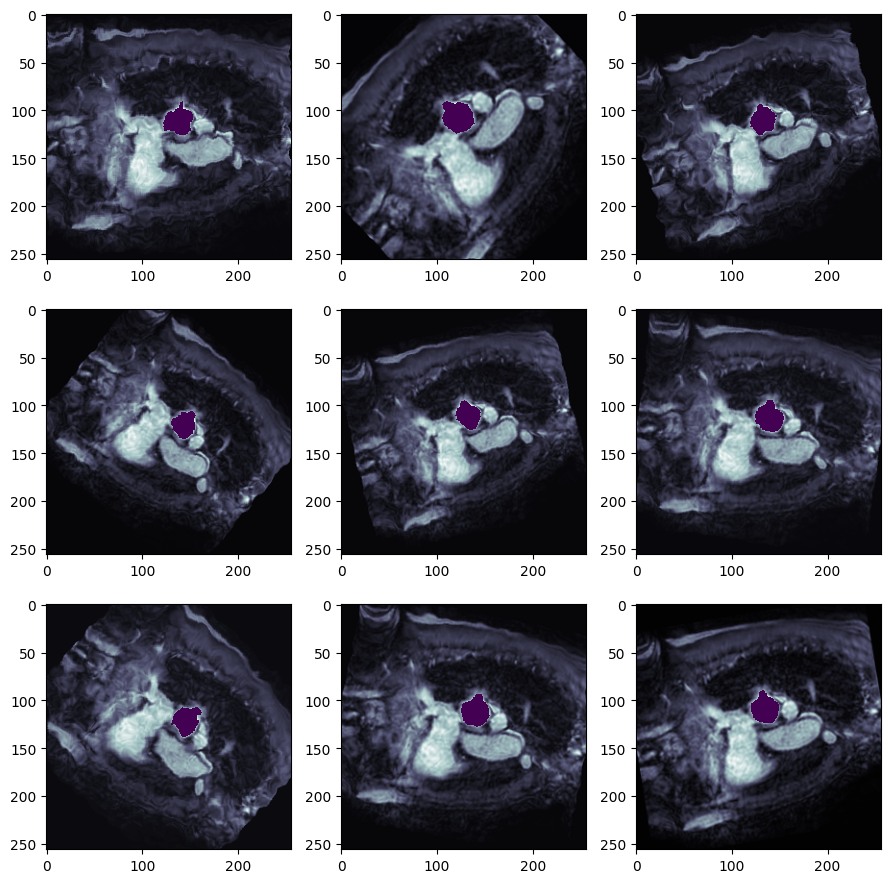

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        slice_data, mask = dataset[10]
        mask_ = np.ma.masked_where(mask == 0, mask)
        axes[i][j].imshow(slice_data[0], cmap='bone')
        axes[i][j].imshow(mask_[0])

plt.tight_layout()

In [13]:
%%writefile dataset.py
from pathlib import Path
import torch
import numpy as np
import imgaug
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

class CardiacDataset(torch.utils.data.Dataset):
    def __init__(self, root, augment_params):
        super().__init__()
        self.all_files = self.extract_files(root)
        self.augment_params = augment_params

    @staticmethod # Means it never accesses any class attributes and doesn't need the 'self' argument
    def extract_files(root):
        files = []

        for subject in root.glob('*'):
            slice_path = subject / 'data'

            for slice_data in slice_path.glob('*.npy'):
                files.append(slice_data)

        return files

    @staticmethod
    def change_img_to_label_path(path):
        '''
        Replaces 'imagesTr' with 'labelsTr'
        '''
        parts = list(path.parts) # get all directories within the path
        parts[parts.index('data')] = 'masks' # Replace 'imagesTr' with 'labelsTr'

        return Path(*parts) # Combine list back into a Path object

    def augment(self, slice_data, mask):
        random_seed = torch.randint(0, 100000, (1, )).item()
        imgaug.seed(random_seed)

        mask = SegmentationMapsOnImage(mask, mask.shape)
        slice_aug, mask_aug = self.augment_params(image=slice_data, segmentation_maps=mask)
        mask_aug = mask_aug.get_arr()

        return slice_aug, mask_aug

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, index):
        file_path = self.all_files[index]
        mask_path = self.change_img_to_label_path(file_path)
        slice_data = np.load(file_path).astype(np.float32)
        mask = np.load(mask_path)

        if self.augment_params:
            slice_data, mask = self.augment(slice_data, mask)

        return np.expand_dims(slice_data, 0), np.expand_dims(mask, 0)

Writing dataset.py


## U-Net Model Implementation

In [ ]:
import torch

class DoubleConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.step = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels,
                            out_channels=out_channels,
                            kernel_size=3,
                            padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=out_channels,
                            out_channels=out_channels,
                            kernel_size=3,
                            padding=1),
            torch.nn.ReLU(),
        )

    def forward(self, X):
        return self.step(X)

In [ ]:
class UNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder layers
        self.layer1 = DoubleConv(in_channels=1, out_channels=64)
        self.layer2 = DoubleConv(in_channels=64, out_channels=128)
        self.layer3 = DoubleConv(in_channels=128, out_channels=256)
        self.layer4 = DoubleConv(in_channels=256, out_channels=512)

        # Decoder layers
        self.layer5 = DoubleConv(in_channels=512 + 256, out_channels=256)
        self.layer6 = DoubleConv(in_channels=256 + 128, out_channels=128)
        self.layer7 = DoubleConv(in_channels=128 + 64, out_channels=64)
        self.layer8 = torch.nn.Conv2d(in_channels=64,
                                      out_channels=1,
                                      kernel_size=1)

        self.maxpool = torch.nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        # Encoder
        x1 = self.layer1(x)
        x1m = self.maxpool(x1)

        x2 = self.layer2(x1m)
        x2m = self.maxpool(x2)

        x3 = self.layer3(x2m)
        x3m = self.maxpool(x3)

        x4 = self.layer4(x3m)

        # Decoder
        x5 = torch.nn.Upsample(scale_factor=2, mode='bilinear')(x4)
        x5 = torch.cat(tensors=[x5, x3], dim=1)
        x5 = self.layer5(x5)

        x6 = torch.nn.Upsample(scale_factor=2, mode='bilinear')(x5)
        x6 = torch.cat(tensors=[x6, x2], dim=1)
        x6 = self.layer6(x6)

        x7 = torch.nn.Upsample(scale_factor=2, mode='bilinear')(x6)
        x7 = torch.cat(tensors=[x7, x1], dim=1)
        x7 = self.layer7(x7)

        # Final Segmentation
        ret = self.layer8(x7)

        return ret

In [ ]:
model = UNet()

random_input = torch.randn(1, 1, 256, 256)
output = model(random_input)

assert output.shape == torch.Size([1, 1, 256, 256])

In [14]:
%%writefile model.py
import torch

class DoubleConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.step = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels,
                            out_channels=out_channels,
                            kernel_size=3,
                            padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=out_channels,
                            out_channels=out_channels,
                            kernel_size=3,
                            padding=1),
            torch.nn.ReLU(),
        )

    def forward(self, X):
        return self.step(X)

class UNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder layers
        self.layer1 = DoubleConv(in_channels=1, out_channels=64)
        self.layer2 = DoubleConv(in_channels=64, out_channels=128)
        self.layer3 = DoubleConv(in_channels=128, out_channels=256)
        self.layer4 = DoubleConv(in_channels=256, out_channels=512)

        # Decoder layers
        self.layer5 = DoubleConv(in_channels=512 + 256, out_channels=256)
        self.layer6 = DoubleConv(in_channels=256 + 128, out_channels=128)
        self.layer7 = DoubleConv(in_channels=128 + 64, out_channels=64)
        self.layer8 = torch.nn.Conv2d(in_channels=64,
                                      out_channels=1,
                                      kernel_size=1)

        self.maxpool = torch.nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        # Encoder
        x1 = self.layer1(x)
        x1m = self.maxpool(x1)

        x2 = self.layer2(x1m)
        x2m = self.maxpool(x2)

        x3 = self.layer3(x2m)
        x3m = self.maxpool(x3)

        x4 = self.layer4(x3m)

        # Decoder
        x5 = torch.nn.Upsample(scale_factor=2, mode='bilinear')(x4)
        x5 = torch.cat(tensors=[x5, x3], dim=1)
        x5 = self.layer5(x5)

        x6 = torch.nn.Upsample(scale_factor=2, mode='bilinear')(x5)
        x6 = torch.cat(tensors=[x6, x2], dim=1)
        x6 = self.layer6(x6)

        x7 = torch.nn.Upsample(scale_factor=2, mode='bilinear')(x6)
        x7 = torch.cat(tensors=[x7, x1], dim=1)
        x7 = self.layer7(x7)

        # Final Segmentation
        ret = self.layer8(x7)

        return ret

Writing model.py


## Data Loading

In [18]:
from pathlib import Path
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import imgaug.augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt

from dataset import CardiacDataset
from model import UNet

In [19]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15),
               rotate=(-45, 45)),
    iaa.ElasticTransformation()
])

train_path = Path('processed/Task02_Heart/train')
val_path = Path('processed/Task02_Heart/train')

train_dataset = CardiacDataset(train_path, seq)
val_dataset = CardiacDataset(val_path, None)

In [20]:
batch_size = 8
num_workers = 0

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               num_workers=num_workers,
                                               shuffle=True)

val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset,
                                             batch_size=batch_size,
                                             num_workers=num_workers,
                                             shuffle=False)

In [21]:
class DiceLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)

        counter = (pred * mask).sum()
        denominator = pred.sum() + mask.sum() + 1e-8
        dice_score = (2 * counter) / denominator

        return 1 - dice_score

## Model Creation

In [22]:
class AtriumSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = UNet()
        self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=1e-4)
        self.loss_fn = DiceLoss()

    def forward(self, data):
        return torch.sigmoid(self.model(data))

    def training_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)

        loss = self.loss_fn(pred, mask)

        self.log('Train Dice', loss)

        if batch_idx % 50 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Train")

        return loss

    def validation_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)

        loss = self.loss_fn(pred, mask)

        self.log('Validation Dice', loss)

        if batch_idx % 2 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Validation")

        return loss

    def log_images(self, mri, pred, mask, name):
        pred = pred > 0.5

        fig, axes = plt.subplots(nrows=1, ncols=2)
        axes[0].imshow(mri[0][0], cmap='bone')
        mask_ = np.ma.masked_where(mask[0][0] == 0, mask[0][0])
        axes[0].imshow(mask_, alpha=0.6)

        axes[1].imshow(mri[0][0], cmap='bone')
        mask_ = np.ma.masked_where(pred[0][0] == 0, pred[0][0])
        axes[1].imshow(mask_, alpha=0.6)

        self.logger.experiment.add_figure(name, fig, self.global_step)

    def configure_optimizers(self):
        return [self.optimizer]

In [ ]:
torch.manual_seed(42)

model = AtriumSegmentation()

checkpoint_callback = ModelCheckpoint(monitor='Validation Dice',
                                      save_top_k=10,
                                      mode='min')

In [ ]:
trainer = pl.Trainer(accelerator='auto',
                     devices='auto',
                     logger=TensorBoardLogger(save_dir='logs'),
                     log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=75)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model=model,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader,
            ckpt_path='/content/logs/lightning_logs/version_4/checkpoints/epoch=65-step=15819.ckpt')

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory logs/lightning_logs/version_4/checkpoints exists and is not empty.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/logs/lightning_logs/version_4/checkpoints/epoch=65-step=15819.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | UNet     | 7.8 M  | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.127    Total estimated model params size (MB)
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/logs/lightning_logs/version_4/checkpoints/epoch=65-step=15819.ckpt


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Model Evaluation

In [23]:
import nibabel as nib
from tqdm.auto import tqdm
from celluloid import Camera

model = AtriumSegmentation.load_from_checkpoint('logs/lightning_logs/version_1/checkpoints/epoch=74-step=17997.ckpt')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.eval();
model.to(device)

AtriumSegmentation(
  (model): UNet(
    (layer1): DoubleConv(
      (step): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer2): DoubleConv(
      (step): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer3): DoubleConv(
      (step): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer4): DoubleConv(
      (step): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2):

In [24]:
preds = []
labels = []

for slice_data, label in tqdm(val_dataset):
    slice_data = torch.tensor(slice_data).to(device).unsqueeze(0)

    with torch.inference_mode():
        pred = model(slice_data)

    preds.append(pred.cpu().numpy())
    labels.append(label)

preds = np.array(preds)
labels = np.array(labels)

  0%|          | 0/1921 [00:00<?, ?it/s]

In [26]:
# This means we almost have perfect predictions and really small error occur
1 - model.loss_fn(torch.from_numpy(preds), torch.from_numpy(labels))

tensor(0.9406)

In [25]:
subject = 'data/Task02_Heart/imagesTs/la_002.nii.gz'
subject_mri = nib.load(subject).get_fdata()

In [27]:
# Helper functions for normalization and standardization
def normalize(full_volume):
    '''
    Z-Normalization of the whole subject
    '''
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std

    return normalized

def standardize(normalized):
    '''
    Standardize the normalized data into the 0-1 range
    '''
    standardized = (normalized - normalized.min()) / (normalized.max() - normalized.min())

    return standardized

In [28]:
subject_mri = subject_mri[32:-32, 32:-32]
standardized_scan = standardize(normalize(subject_mri))

In [29]:
preds = []

for i in range(standardized_scan.shape[-1]):
    slice_data = standardized_scan[:, :, i]

    with torch.inference_mode():
        pred = model(torch.tensor(slice_data).unsqueeze(0).unsqueeze(0).float().to(device))[0][0]
        pred = pred > 0.5

    preds.append(pred.cpu())

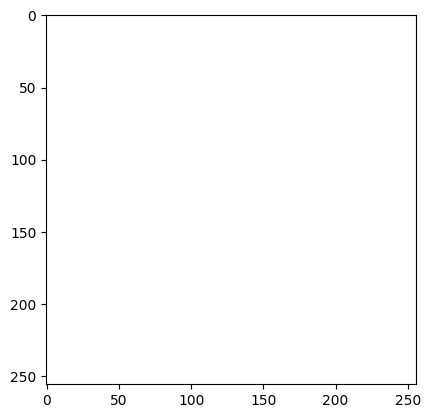

In [30]:
fig = plt.figure()
camera = Camera(fig)

for i in range(standardized_scan.shape[-1]):
    plt.imshow(standardized_scan[:, :, i], cmap='bone')
    mask= np.ma.masked_where(preds[i] == 0, preds[i])
    plt.imshow(mask, alpha=0.5)
    camera.snap()

animation = camera.animate()

In [31]:
from IPython.display import HTML

HTML(animation.to_html5_video())